In [1]:
# Fraud Detection Analysis
# Author: Sera Park
# Description: Detecting fraudulent transactions using EDA and machine learning models

In [2]:
import os
os.makedirs('images', exist_ok=True)

def save_fig(filename):
    plt.savefig(f'images/{filename}', dpi=300, bbox_inches='tight')

## Import Data

In [3]:
import pandas as pd
import numpy as np

In [4]:
# path = '/Fraud.csv'
data = pd.read_csv(path)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
data.duplicated().sum()

0

## Data Overview

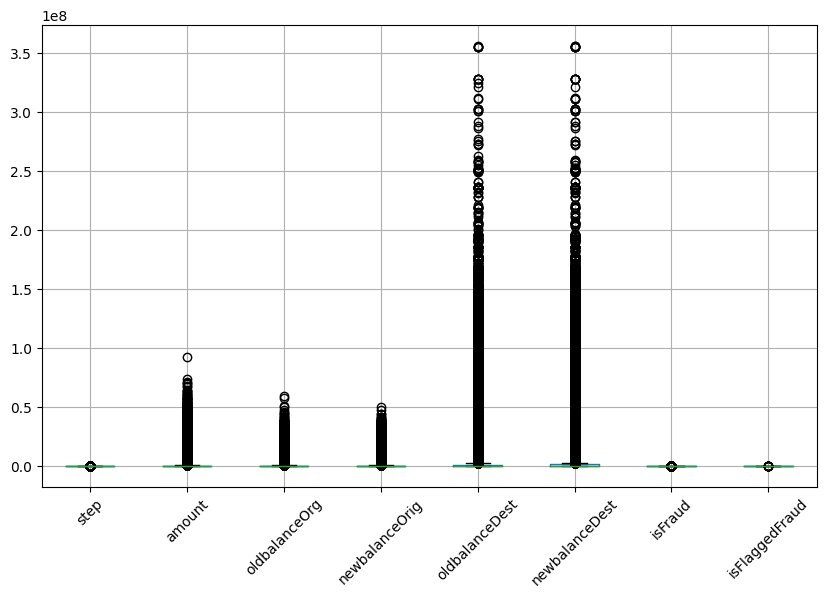

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
data.boxplot()
plt.xticks(rotation=45)

plt.show()

In [10]:
def detect_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    if outliers.empty:
        return column, 0.0
    else:
        percentage = (len(outliers) / len(data)) * 100
        return column, percentage

In [11]:
def remove_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    result = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    result.reset_index(drop=True)
    return result

In [12]:
for column in data.select_dtypes(include=['int64', 'float64']):
    column_, percentage = detect_outliers(data, column)
    print(f'Column: {column}\noutliers: {percentage:.2f}%\n')

Column: step
outliers: 1.61%

Column: amount
outliers: 5.31%

Column: oldbalanceOrg
outliers: 17.49%

Column: newbalanceOrig
outliers: 16.56%

Column: oldbalanceDest
outliers: 12.36%

Column: newbalanceDest
outliers: 11.61%

Column: isFraud
outliers: 0.13%

Column: isFlaggedFraud
outliers: 0.00%



In [13]:
fraud_data = data[data['isFraud'] == 1]

print(fraud_data['isFlaggedFraud'].value_counts(), '\n')
print(round(fraud_data['isFlaggedFraud'].value_counts()/ len(fraud_data) * 100, 2))

isFlaggedFraud
0    8197
1      16
Name: count, dtype: int64 

isFlaggedFraud
0    99.81
1     0.19
Name: count, dtype: float64


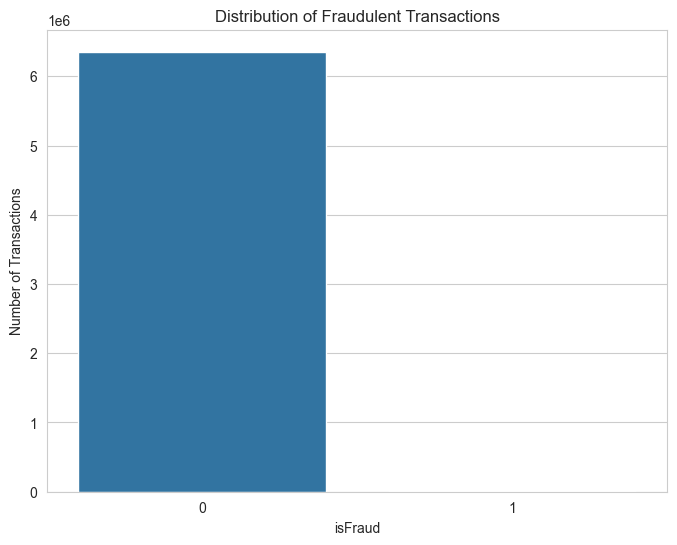

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='isFraud')
plt.title('Distribution of Fraudulent Transactions')
plt.ylabel('Number of Transactions')
plt.show()


In [15]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

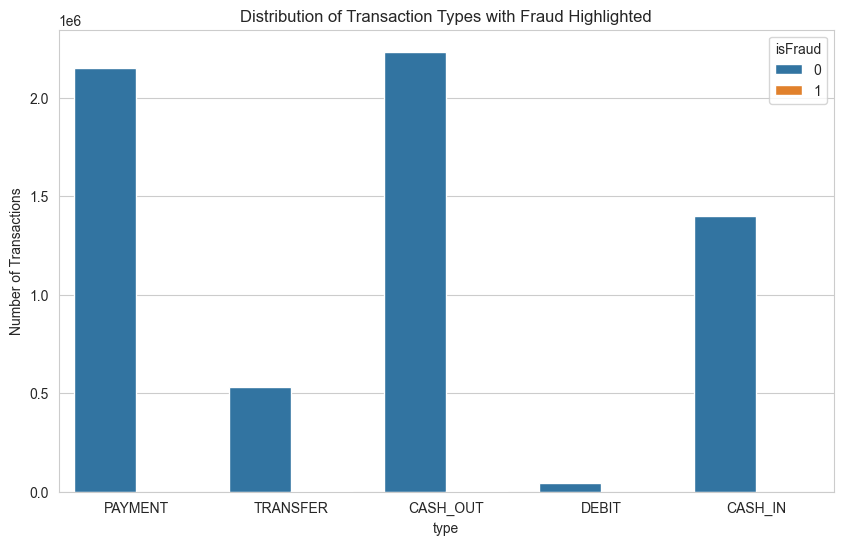

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='isFraud')
plt.title('Distribution of Transaction Types with Fraud Highlighted')
plt.ylabel('Number of Transactions')
plt.show()

In [17]:
data.groupby('isFraud')['type'].value_counts()

isFraud  type    
0        CASH_OUT    2233384
         PAYMENT     2151495
         CASH_IN     1399284
         TRANSFER     528812
         DEBIT         41432
1        CASH_OUT       4116
         TRANSFER       4097
Name: count, dtype: int64

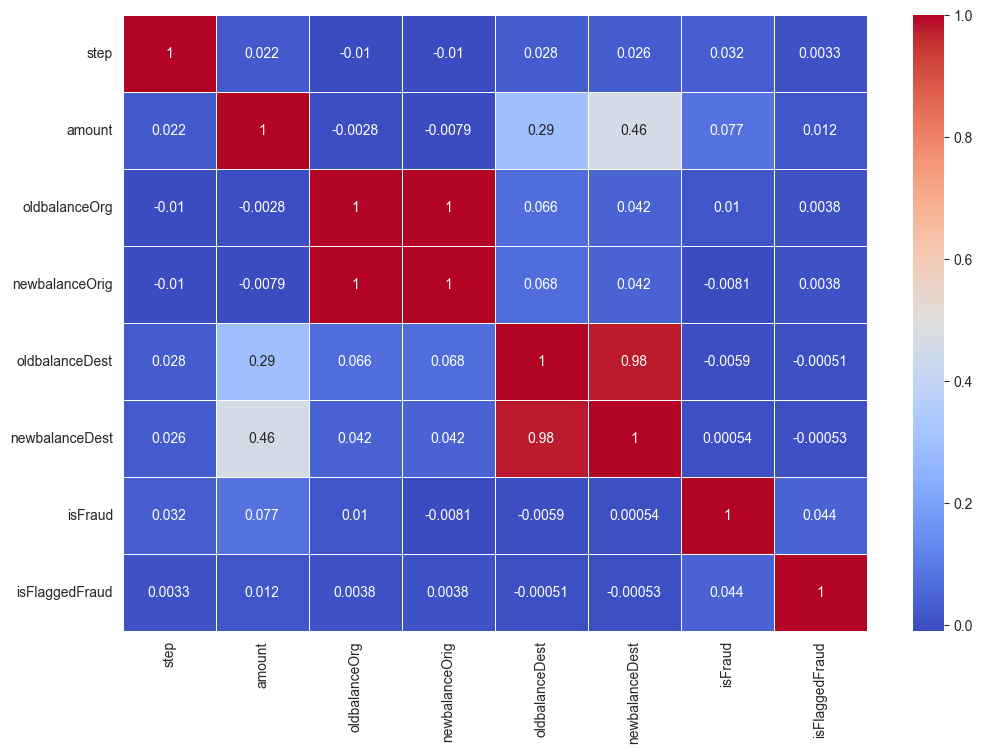

<Figure size 640x480 with 0 Axes>

In [18]:
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

save_fig('correlation_matrix.png')

In [19]:
data['balanceDiffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balanceDiffDest'] = data['oldbalanceDest'] - data['newbalanceDest']

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,21182.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [20]:
data_encoded = pd.get_dummies(data, columns=['type'], drop_first=True)

data_encoded.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,21182.0,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0,False,False,True,False


### Multicollinearity

In [21]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(0)
x1 = np.random.rand(100)
x2 = x1 + np.random.normal(0, 0.1, 100)

y = 2*x1 + 3*x2 + np.random.normal(0, 0.1, 100)

In [22]:
X = np.column_stack((x1, x2))
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [23]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif['features'] = ["Intercept", "x1", 'x2']

model.summary(), vif

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.996
 Model:                            OLS   Adj. R-squared:                  0.996
 Method:                 Least Squares   F-statistic:                 1.100e+04
 Date:                Wed, 06 Aug 2025   Prob (F-statistic):          4.64e-115
 Time:                        14:33:23   Log-Likelihood:                 91.216
 No. Observations:                 100   AIC:                            -176.4
 Df Residuals:                      97   BIC:                            -168.6
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [24]:
X_reduced = X[:, [0, 2]]
model_reduced = sm.OLS(y, X_reduced).fit()

vif_reduced = pd.DataFrame()
vif_reduced["VIF Factor"] = [variance_inflation_factor(X_reduced, i) for i in range(X_reduced.shape[1])]
vif_reduced['features'] = ["Intercept", 'x2']

model_reduced.summary(), vif_reduced

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.981
 Model:                            OLS   Adj. R-squared:                  0.981
 Method:                 Least Squares   F-statistic:                     5109.
 Date:                Wed, 06 Aug 2025   Prob (F-statistic):           2.32e-86
 Time:                        14:33:23   Log-Likelihood:                 18.454
 No. Observations:                 100   AIC:                            -32.91
 Df Residuals:                      98   BIC:                            -27.70
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

## EDA

### By Transaction Type

/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/2375566579.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='isFraud', data=fraud_by_type, palette='viridis')


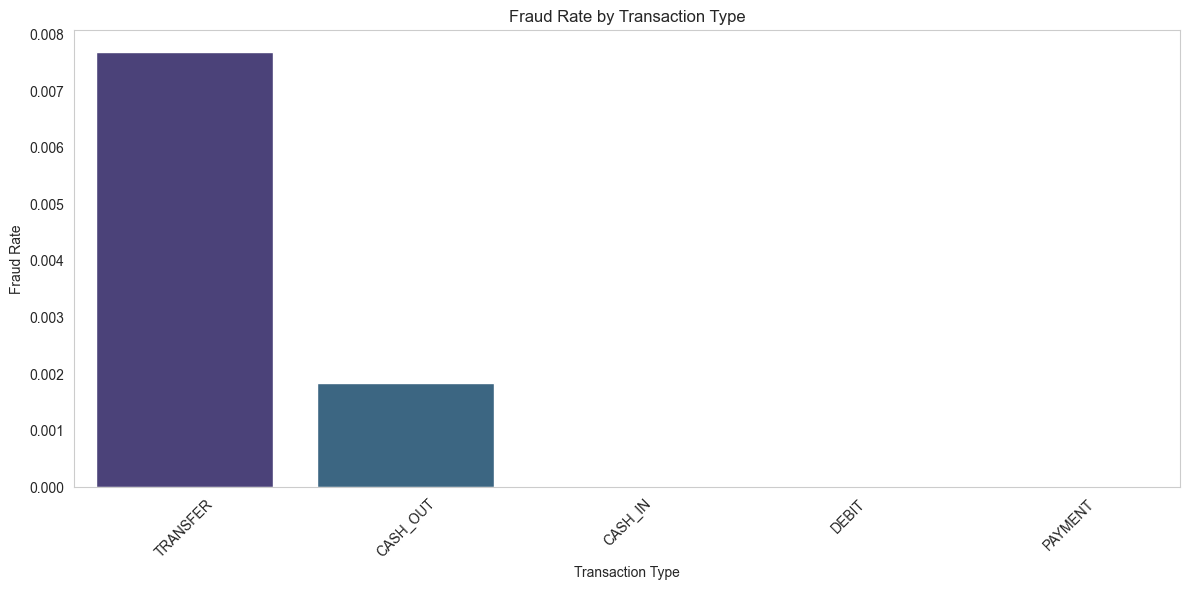

In [25]:
fraud_by_type = data.groupby('type').agg({
    'isFraud': 'mean'
}).reset_index().sort_values(by='isFraud', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='isFraud', data=fraud_by_type, palette='viridis')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Transaction Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

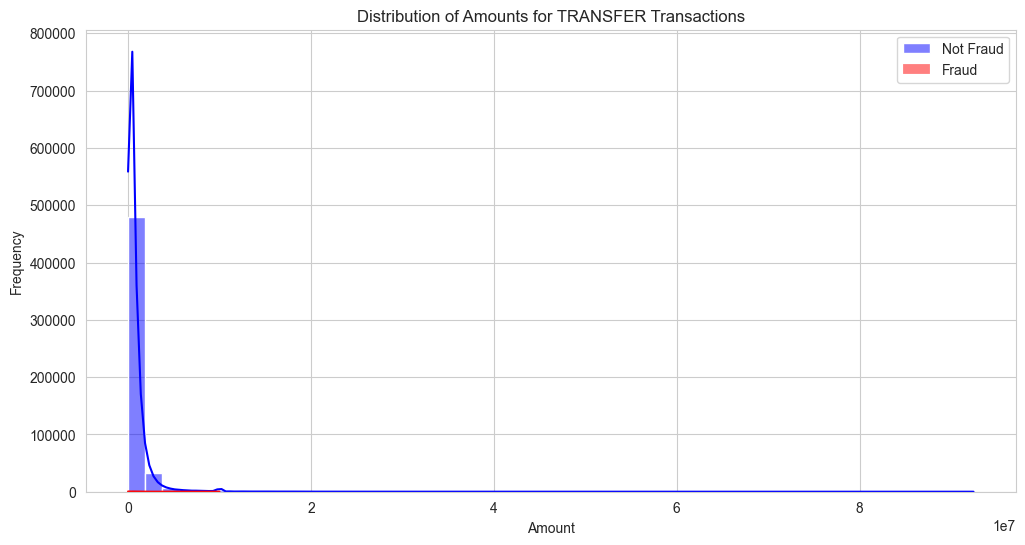

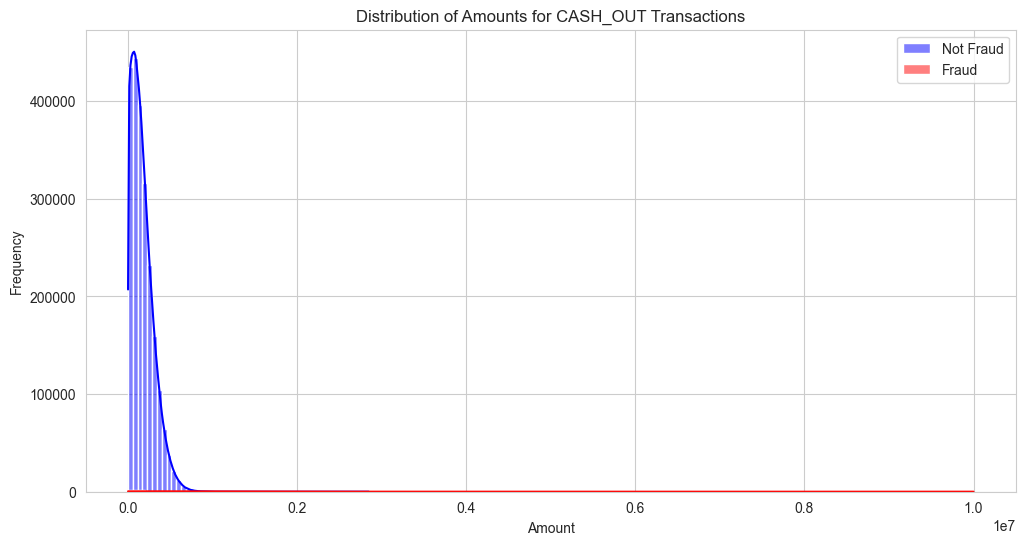

In [26]:
transfer_data = data[data['type'] == 'TRANSFER']
cashout_data = data[data['type'] == 'CASH_OUT']

# TRANSFER
plt.figure(figsize=(12, 6))
sns.histplot(transfer_data[transfer_data['isFraud'] == 0]['amount'], bins=50, color='blue', kde='True', label='Not Fraud')
sns.histplot(transfer_data[transfer_data['isFraud'] == 1]['amount'], bins=50, color='red', kde='True', label='Fraud')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amounts for TRANSFER Transactions')
plt.legend()
save_fig('amount_distribution_transfer.png')
plt.show()

# CASH OUT
plt.figure(figsize=(12, 6))
sns.histplot(cashout_data[cashout_data['isFraud'] == 0]['amount'], bins=50, color='blue', kde='True', label='Not Fraud')
sns.histplot(cashout_data[cashout_data['isFraud'] == 1]['amount'], bins=50, color='red', kde='True', label='Fraud')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amounts for CASH_OUT Transactions')
plt.legend()
save_fig('amount_distribution_cashout.png') 
plt.show()


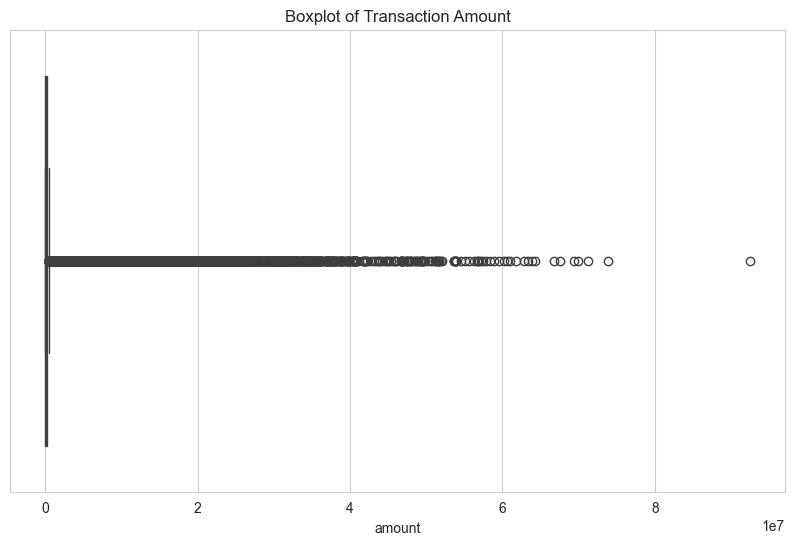

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_encoded, x='amount')
plt.title('Boxplot of Transaction Amount')
save_fig('boxplot_transaction_amount.png')
plt.show()



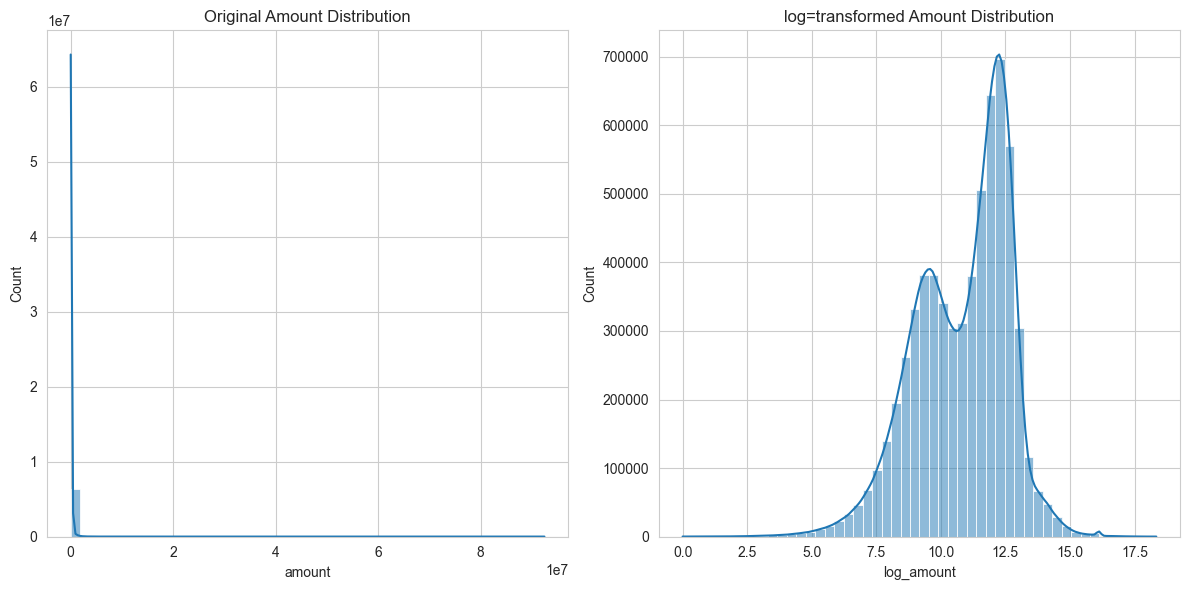

In [28]:
import numpy as np

data_encoded['log_amount'] = np.log1p(data_encoded['amount'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_encoded['amount'], bins=50, kde=True)
plt.title('Original Amount Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data_encoded['log_amount'], bins=50, kde=True)
plt.title('log=transformed Amount Distribution')

plt.tight_layout()
save_fig('amount_distribution_log_transformed.png')

plt.show()

/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/3664501401.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 0]['log_amount'], color='blue', label='Not Fraud', shade=True)
/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/3664501401.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 1]['log_amount'], color='red', label='Fraud', shade=True)


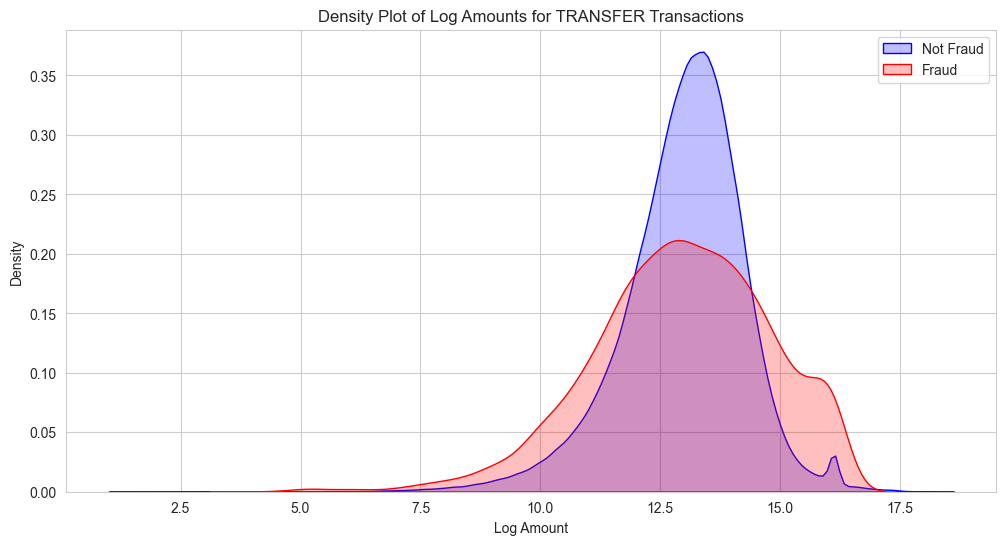

/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/3664501401.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 0]['log_amount'], color='blue', label='Not Fraud', shade=True)
/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/3664501401.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 1]['log_amount'], color='red', label='Fraud', shade=True)


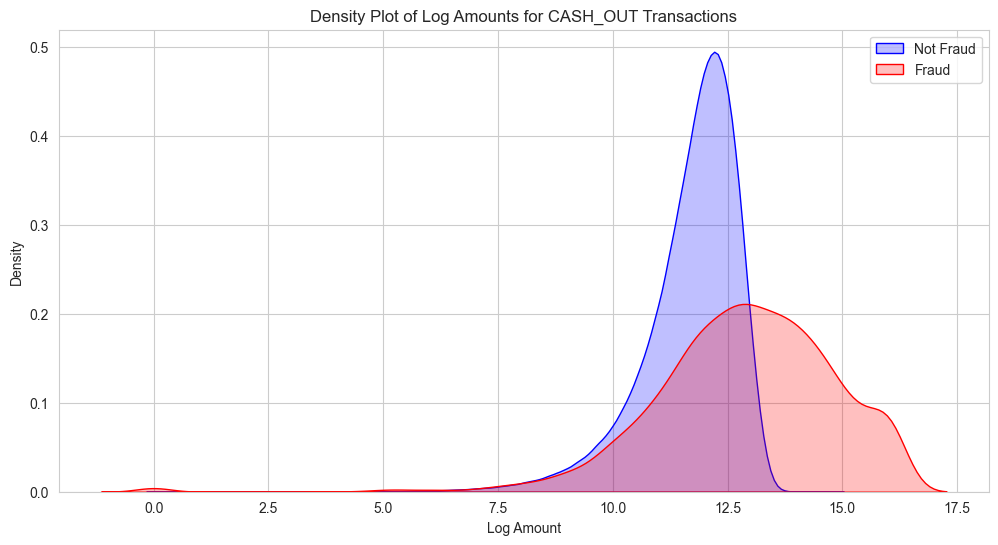

In [29]:
transfer_data_encoded = data_encoded[data_encoded['type_TRANSFER'] == 1]
cashout_data_encoded = data_encoded[data_encoded['type_CASH_OUT'] == 1]

plt.figure(figsize=(12, 6))
sns.kdeplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 0]['log_amount'], color='blue', label='Not Fraud', shade=True)
sns.kdeplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 1]['log_amount'], color='red', label='Fraud', shade=True)
plt.xlabel('Log Amount')
plt.ylabel('Density')
plt.title('Density Plot of Log Amounts for TRANSFER Transactions')
plt.legend()
save_fig('log_amount_density_transfer.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 0]['log_amount'], color='blue', label='Not Fraud', shade=True)
sns.kdeplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 1]['log_amount'], color='red', label='Fraud', shade=True)
plt.xlabel('Log Amount')
plt.ylabel('Density')
plt.title('Density Plot of Log Amounts for CASH_OUT Transactions')
plt.legend()
save_fig('log_amount_density_cashout.png')
plt.show()

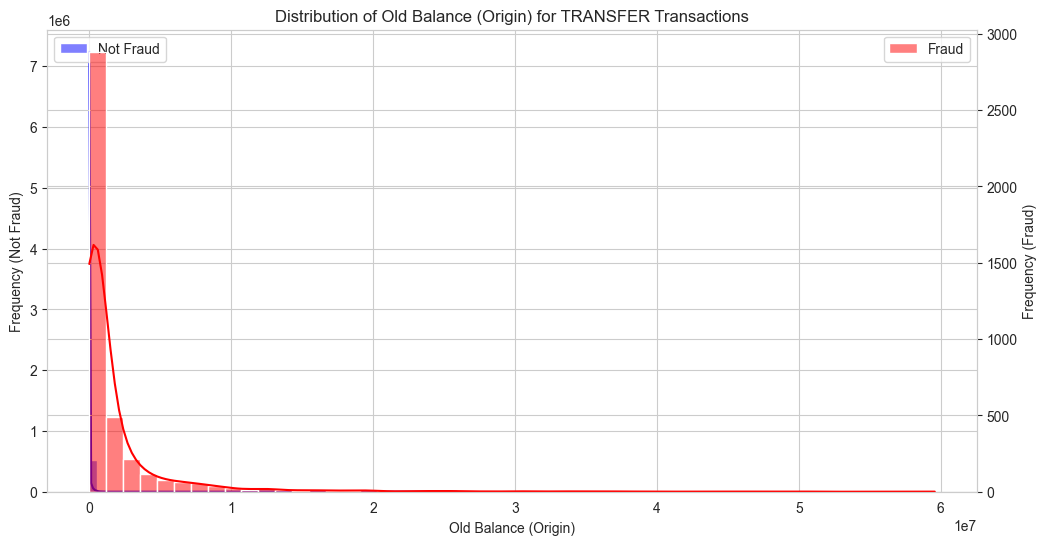

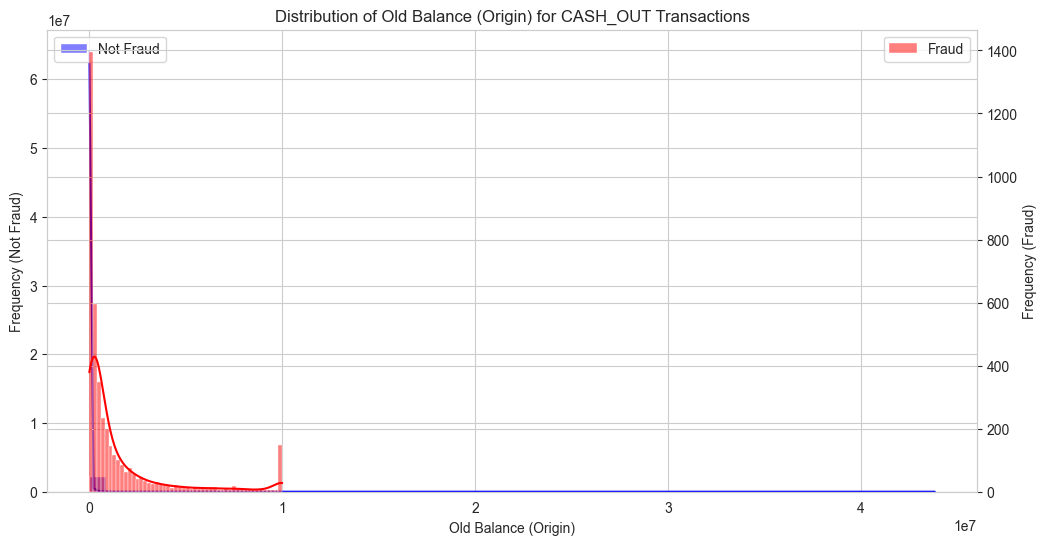

In [30]:
#TRANSFER
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

sns.histplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 0]['oldbalanceOrg'],
             bins=50, color='blue', kde=True, label='Not Fraud', ax=ax)
ax.set_xlabel('Old Balance (Origin)')
ax.set_ylabel('Frequency (Not Fraud)')
ax.set_title('Distribution of Old Balance (Origin) for TRANSFER Transactions')
ax.legend(loc='upper left')

sns.histplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 1]['oldbalanceOrg'],
             bins=50, color='red', kde=True, label='Fraud', ax=ax2)
ax2.set_ylabel('Frequency (Fraud)')
ax2.legend(loc='upper right')
save_fig('oldbalance_distribution_transfer.png')

plt.show()

#CASH OUT
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

sns.histplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 0]['oldbalanceOrg'],
             bins=50, color='blue', kde=True, label='Not Fraud', ax=ax)
ax.set_xlabel('Old Balance (Origin)')
ax.set_ylabel('Frequency (Not Fraud)')
ax.set_title('Distribution of Old Balance (Origin) for CASH_OUT Transactions')
ax.legend(loc='upper left')

sns.histplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 1]['oldbalanceOrg'],
             bins=50, color='red', kde=True, label='Fraud', ax=ax2)
ax2.set_ylabel('Frequency (Fraud)')
ax2.legend(loc='upper right')
save_fig('oldbalance_distribution_cashout.png')

plt.show()

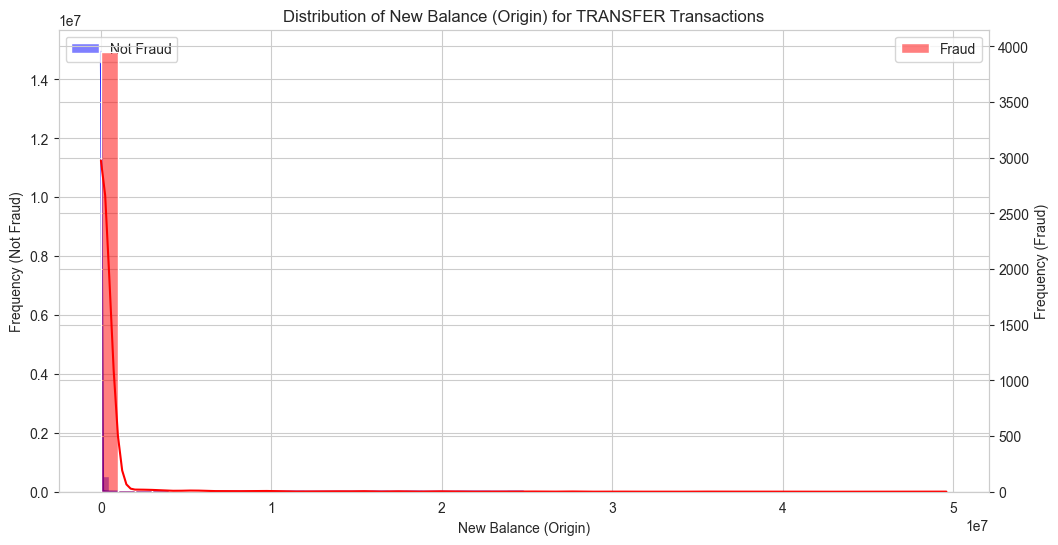

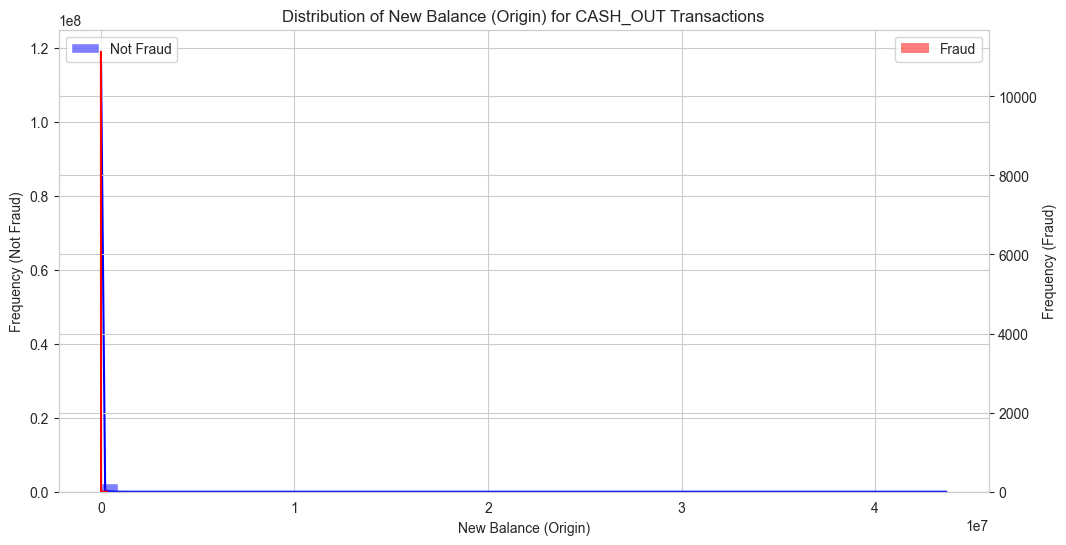

In [31]:
# TRANSFER
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

sns.histplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 0]['newbalanceOrig'],
             bins=50, color='blue', kde=True, label='Not Fraud', ax=ax)
ax.set_xlabel('New Balance (Origin)')
ax.set_ylabel('Frequency (Not Fraud)')
ax.set_title('Distribution of New Balance (Origin) for TRANSFER Transactions')
ax.legend(loc='upper left')

sns.histplot(transfer_data_encoded[transfer_data_encoded['isFraud'] == 1]['newbalanceOrig'],
             bins=50, color='red', kde=True, label='Fraud', ax=ax2)
ax2.set_ylabel('Frequency (Fraud)')
ax2.legend(loc='upper right')
save_fig('newbalance_distribution_transfer.png')

plt.show()



# CASH OUT
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()

sns.histplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 0]['newbalanceOrig'],
             bins=50, color='blue', kde=True, label='Not Fraud', ax=ax)
ax.set_xlabel('New Balance (Origin)')
ax.set_ylabel('Frequency (Not Fraud)')
ax.set_title('Distribution of New Balance (Origin) for CASH_OUT Transactions')
ax.legend(loc='upper left')

sns.histplot(cashout_data_encoded[cashout_data_encoded['isFraud'] == 1]['newbalanceOrig'],
             bins=50, color='red', kde=True, label='Fraud', ax=ax2)
ax2.set_ylabel('Frequency (Fraud)')
ax2.legend(loc='upper right')
save_fig('newbalance_distribution_cashout.png')

plt.show()

In [32]:
transfer_data_encoded['hour_of_day'] = transfer_data_encoded['step'] % 24
cashout_data_encoded['hour_of_day'] = cashout_data_encoded['step'] % 24

/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/2513429837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfer_data_encoded['hour_of_day'] = transfer_data_encoded['step'] % 24
/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/2513429837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cashout_data_encoded['hour_of_day'] = cashout_data_encoded['step'] % 24


In [33]:
transfer_time_trend = transfer_data_encoded.groupby('hour_of_day').agg({
    'isFraud': ['sum', 'count']
}).reset_index()
transfer_time_trend.columns = ['hour_of_day', 'fraud_count', 'total_count']
transfer_time_trend['fraud_rate'] = transfer_time_trend['fraud_count'] / transfer_time_trend['total_count']

cashout_time_trend = cashout_data_encoded.groupby('hour_of_day').agg({
    'isFraud': ['sum', 'count']
}).reset_index()
cashout_time_trend.columns = ['hour_of_day', 'fraud_count', 'total_count']
cashout_time_trend['fraud_rate'] = cashout_time_trend['fraud_count'] / cashout_time_trend['total_count']


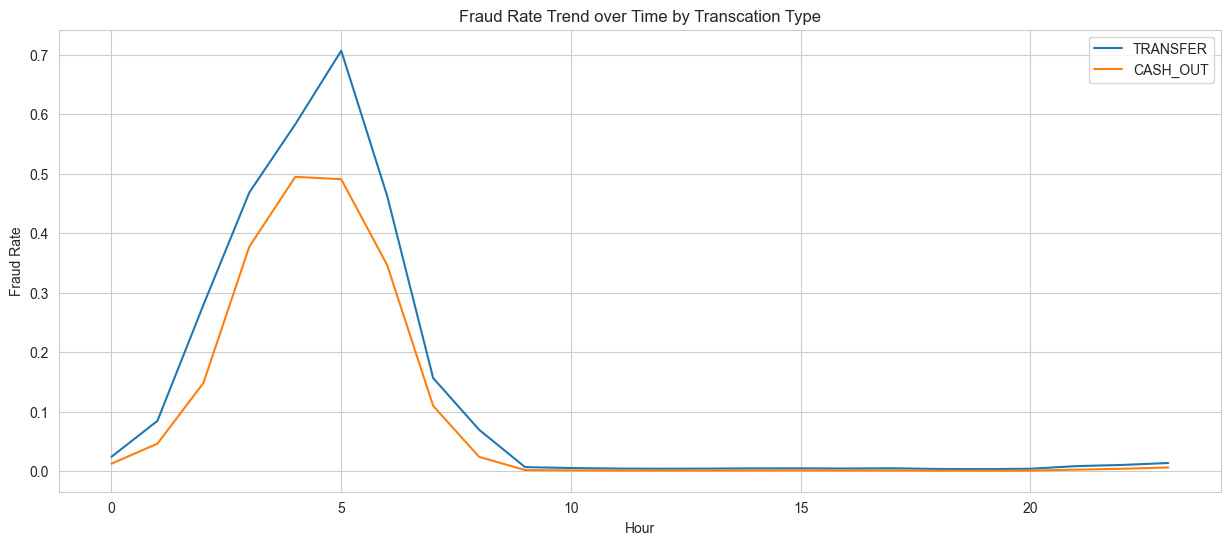

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(transfer_time_trend['hour_of_day'], transfer_time_trend['fraud_rate'], label='TRANSFER')
plt.plot(cashout_time_trend['hour_of_day'], cashout_time_trend['fraud_rate'], label='CASH_OUT')
plt.title('Fraud Rate Trend over Time by Transcation Type')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.legend()
save_fig('fraud_rate_trend_by_hour.png')

plt.show()

In [35]:
transfer_time_trend

,hour_of_day,fraud_count,total_count,fraud_rate
0,0,150,6217,0.024127
1,1,178,2107,0.084480
2,2,186,666,0.279279
3,3,163,348,0.468391
4,4,137,235,0.582979
5,5,183,259,0.706564
6,6,179,387,0.462532
7,7,164,1048,0.156489
8,8,184,2643,0.069618
9,9,171,25203,0.006785


### By Segmentation (based on amount) of Transaction

In [36]:
threshold = data_encoded['amount'].quantile(0.90)

typical_transactions = data_encoded[data_encoded['amount'] <= threshold]
high_value_transactions = data_encoded[data_encoded['amount'] > threshold]

print(f"Number of Typical Transactions: {typical_transactions.shape[0]}")
print(f"Number of Hogh-Value Transactions: {high_value_transactions.shape[0]}")

Number of Typical Transactions: 5726358
Number of Hogh-Value Transactions: 636262


In [37]:
typical_fraud_rate = typical_transactions['isFraud'].mean()
high_value_fraud_rate = high_value_transactions['isFraud'].mean()

print(f"Fraud Rate in Typical Transactions: {typical_fraud_rate:.2%}")
print(f"Fraud Rate in High-Value Transactions: {high_value_fraud_rate:.2%}")

Fraud Rate in Typical Transactions: 0.07%
Fraud Rate in High-Value Transactions: 0.69%


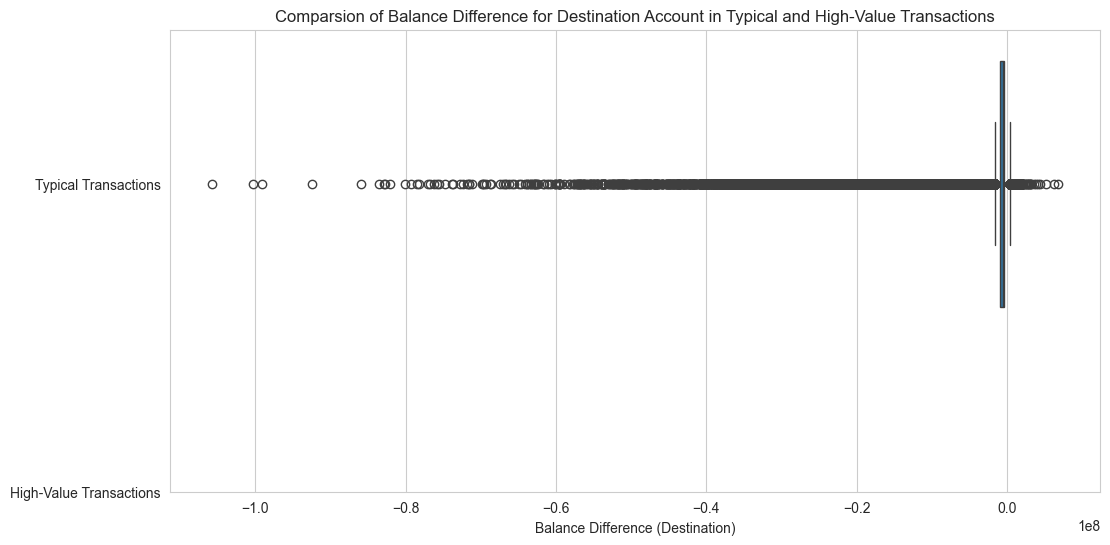

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=[typical_transactions['balanceDiffDest'], high_value_transactions['balanceDiffDest']], orient='h')
plt.yticks([0,1], ['Typical Transactions', 'High-Value Transactions'])
plt.xlabel('Balance Difference (Destination)')
plt.title('Comparsion of Balance Difference for Destination Account in Typical and High-Value Transactions')
save_fig('balance_diff_dest_boxplot.png')
plt.show()

In [39]:
f_typical_transactions = remove_outliers(typical_transactions, 'balanceDiffDest')
f_high_value_transactions = remove_outliers(high_value_transactions, 'balanceDiffDest')

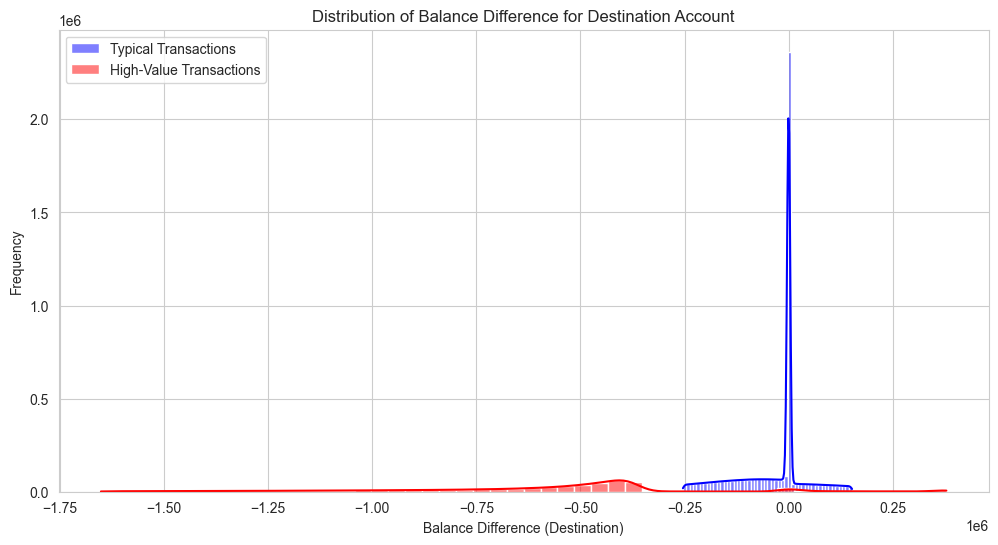

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(f_typical_transactions['balanceDiffDest'], bins=50, color='blue', kde=True, label='Typical Transactions')
sns.histplot(f_high_value_transactions['balanceDiffDest'], bins=50, color='red', kde=True, label='High-Value Transactions')
plt.title('Distribution of Balance Difference for Destination Account')
plt.xlabel('Balance Difference (Destination)')
plt.ylabel('Frequency')
plt.legend()
save_fig('balance_diff_dest_distribution.png')
plt.show()

In [41]:
typical_corr = typical_transactions.select_dtypes(include=[np.number]).corr()
high_value_corr = high_value_transactions.select_dtypes(include=[np.number]).corr()

typical_isFraud_corr = typical_corr['isFraud'].drop('isFraud')
high_value_isFraud_corr = high_value_corr['isFraud'].drop('isFraud')

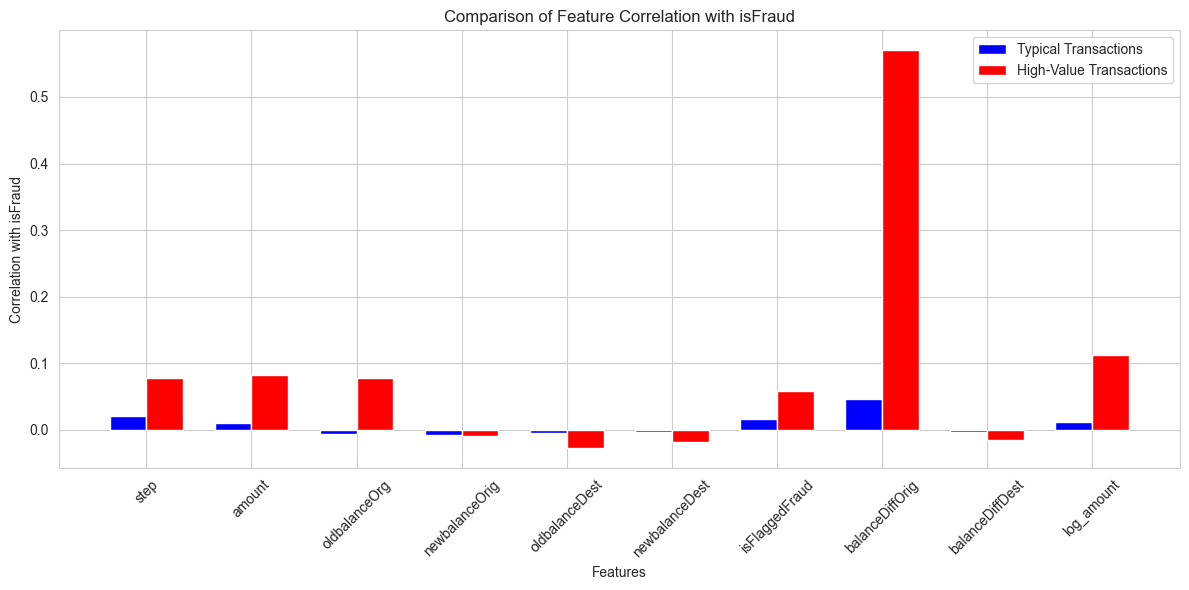

In [42]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
indicies = np.arange(len(typical_isFraud_corr))

plt.bar(indicies, typical_isFraud_corr, bar_width, color='blue', label='Typical Transactions')
plt.bar(indicies + bar_width, high_value_isFraud_corr, bar_width, color='red', label='High-Value Transactions')

plt.xlabel('Features')
plt.ylabel('Correlation with isFraud')
plt.title('Comparison of Feature Correlation with isFraud')
plt.xticks(indicies + bar_width / 2, typical_isFraud_corr.index, rotation=45)
plt.legend()
plt.tight_layout()
save_fig('feature_correlation_isfraud.png')
plt.show()

### By Time Trend

In [43]:
time_analysis = data_encoded.groupby('step').agg({'isFraud': ['count', 'sum']}).reset_index()
time_analysis.columns = ['step', 'total_transactions', 'fraudelent_transactions']

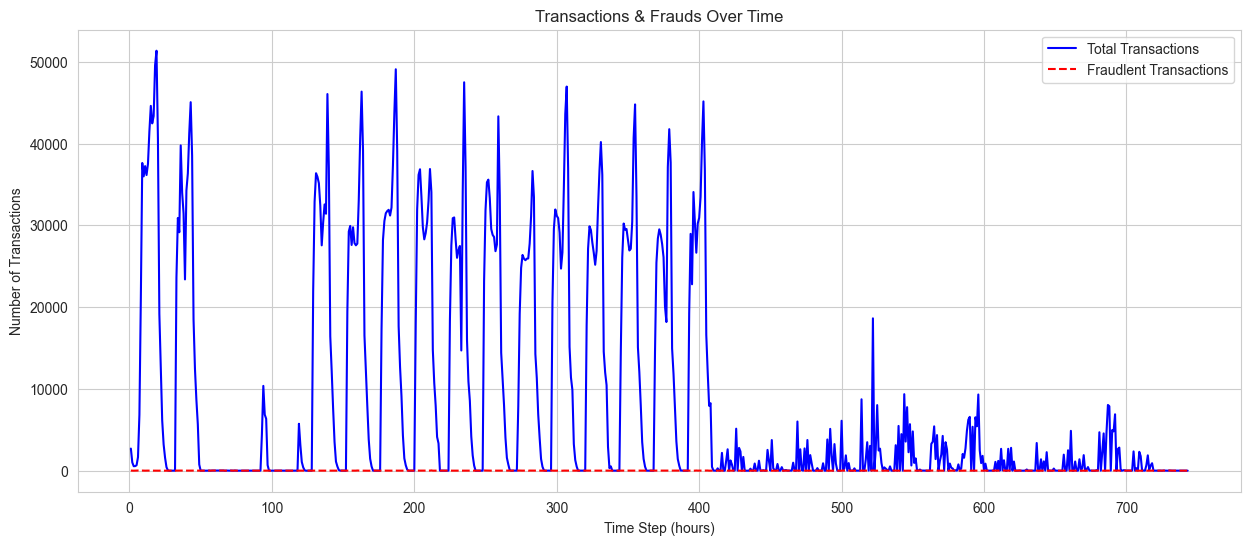

In [44]:
plt.figure(figsize=(15, 6))

plt.plot(time_analysis['step'], time_analysis['total_transactions'], label='Total Transactions', color='blue')
plt.plot(time_analysis['step'], time_analysis['fraudelent_transactions'], label='Fraudlent Transactions', color='red', linestyle='dashed')
plt.xlabel('Time Step (hours)')
plt.ylabel('Number of Transactions')
plt.title('Transactions & Frauds Over Time')
plt.legend()
plt.grid(True)
save_fig('transactions_frauds_over_time.png')

plt.show()

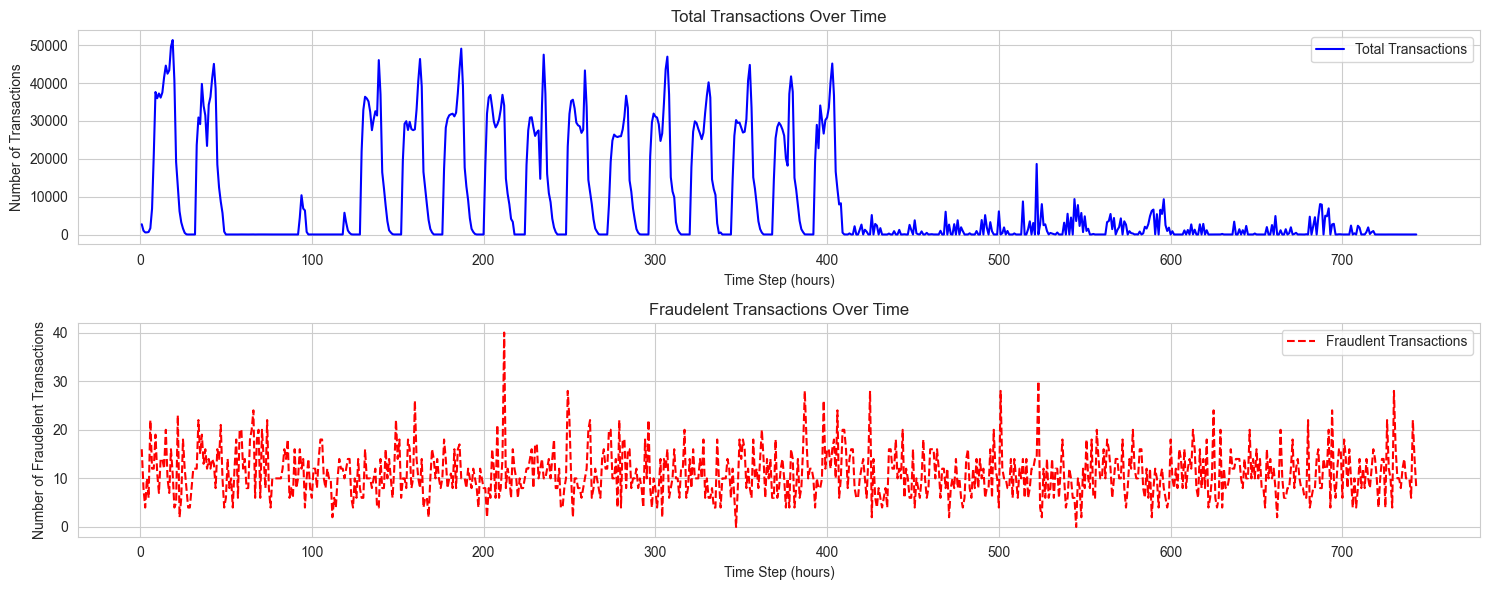

In [45]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(time_analysis['step'], time_analysis['total_transactions'], label='Total Transactions', color='blue')
plt.xlabel('Time Step (hours)')
plt.ylabel('Number of Transactions')
plt.title('Total Transactions Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.subplot(2, 1, 2)
plt.plot(time_analysis['step'], time_analysis['fraudelent_transactions'], label='Fraudlent Transactions', color='red', linestyle='dashed')
plt.xlabel('Time Step (hours)')
plt.ylabel('Number of Fraudelent Transactions')
plt.title('Fraudelent Transactions Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
save_fig('total_vs_fraud_transactions_subplots.png')

plt.show()

In [46]:
balance_diff_analysis = data_encoded.groupby('step').agg({
    'balanceDiffOrig': 'mean',
    'balanceDiffDest': 'mean'
}).reset_index()

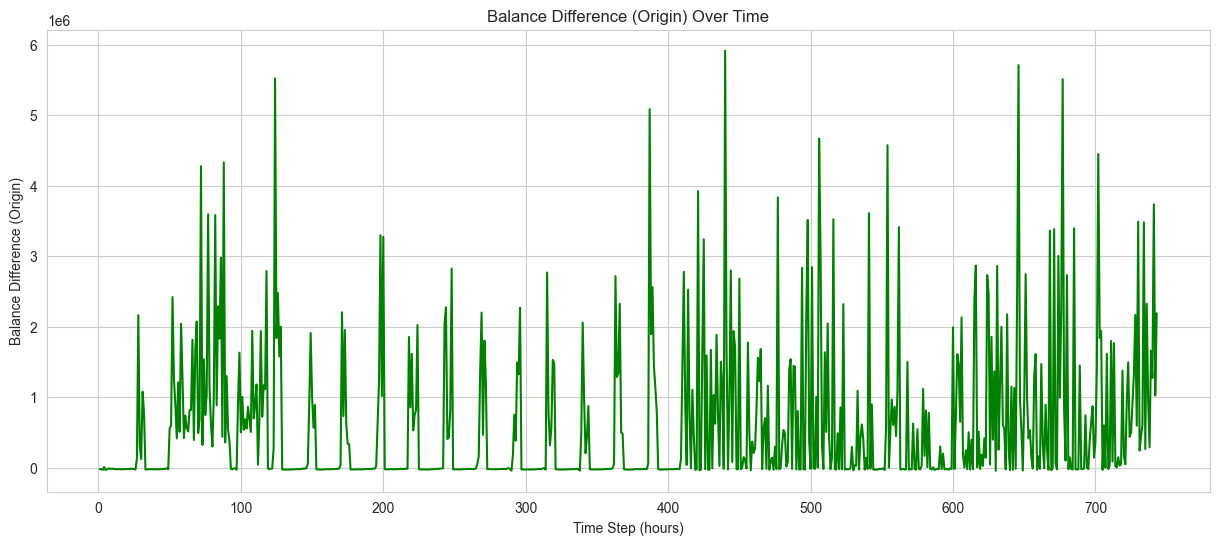

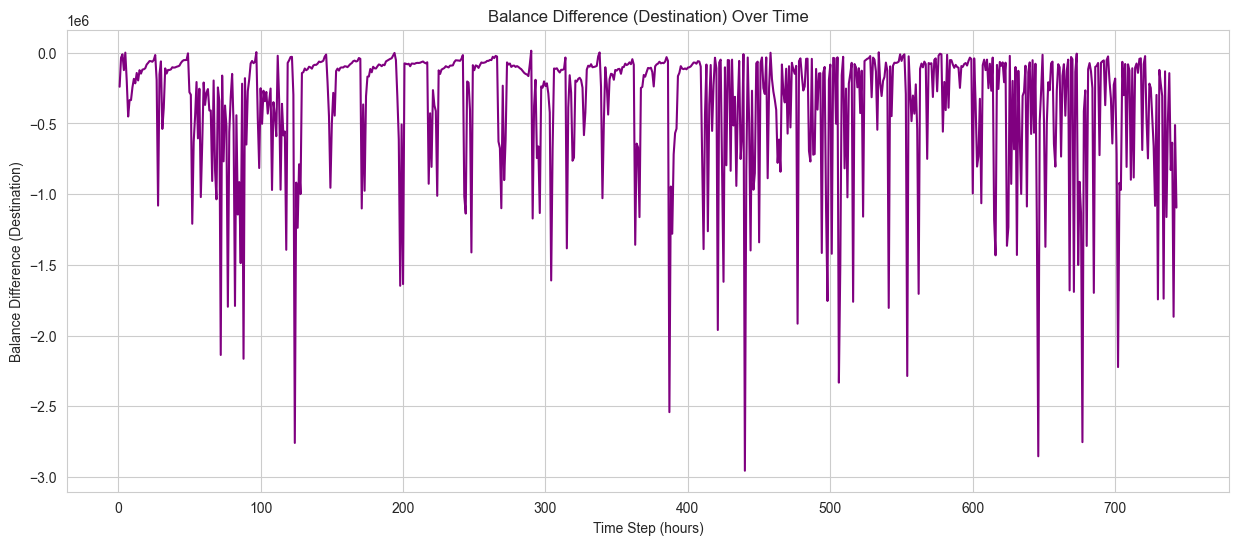

In [47]:
plt.figure(figsize=(15, 6))

plt.plot(balance_diff_analysis['step'], balance_diff_analysis['balanceDiffOrig'], label='Balance Difference (Origin)', color='green')
plt.xlabel('Time Step (hours)')
plt.ylabel('Balance Difference (Origin)')
plt.title('Balance Difference (Origin) Over Time')
plt.grid(True)
save_fig('balance_diff_origin_over_time.png')

plt.show()

plt.figure(figsize=(15, 6))

plt.plot(balance_diff_analysis['step'], balance_diff_analysis['balanceDiffDest'], label='Balance Difference (Destination)', color='purple')
plt.xlabel('Time Step (hours)')
plt.ylabel('Balance Difference (Destination)')
plt.title('Balance Difference (Destination) Over Time')
plt.grid(True)
save_fig('balance_diff_dest_over_time.png')

plt.show()

In [48]:
rolling_mean = time_analysis['fraudelent_transactions'].rolling(window=10).mean()
rolling_std = time_analysis['fraudelent_transactions'].rolling(window=10).std()

spikes = time_analysis[time_analysis['fraudelent_transactions'] > (rolling_mean + 2*rolling_std)]

print("Steps with significant spikes in fraudelent transactions:\n", spikes['step'].values)

Steps with significant spikes in fraudelent transactions:
 [ 47  84  86 149 160 208 212 241 249 261 296 317 387 398 425 436 501 523
 600 646 680 741]


/var/folders/gv/ldw6vdkx3tn58ym0_xrj0lg00000gn/T/ipykernel_22790/3840307260.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette='mako')


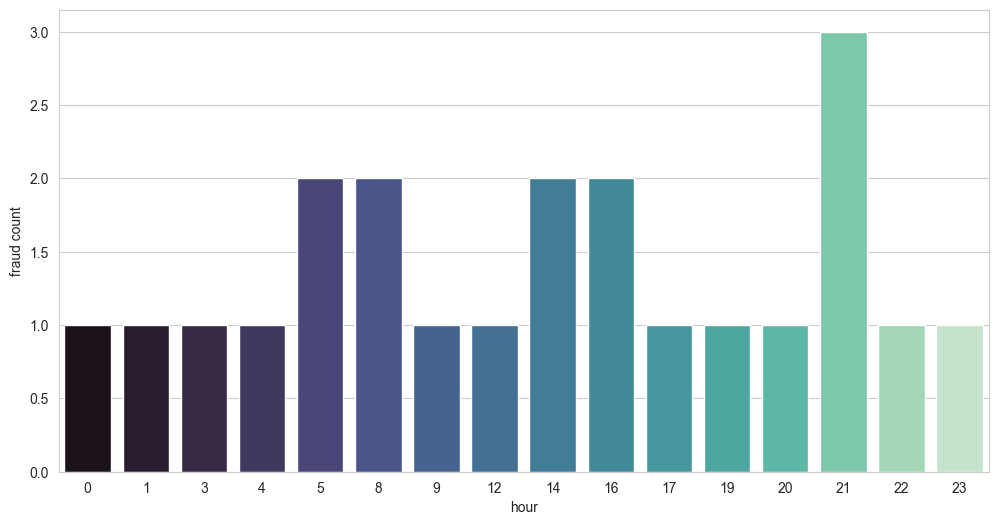

In [49]:
from collections import Counter

spikes_lst = sorted(list(Counter(spikes['step'] % 24).items()))
x = [x for x,_ in spikes_lst]
y = [y for _,y in spikes_lst]

plt.figure(figsize=(12, 6))
sns.barplot(x=x, y=y, palette='mako')
plt.xlabel('hour')
plt.ylabel('fraud count')
save_fig('fraud_spikes_by_hour.png')

plt.show()

In [50]:
data_encoded['hour_of_day'] = data_encoded['step'] % 24

hourly_analysis = data_encoded.groupby('hour_of_day').agg({
    'isFraud': ['count', 'sum']
}).reset_index()

hourly_analysis.columns = ['hour_of_day', 'total_transactions', 'fraudelent_transactions']

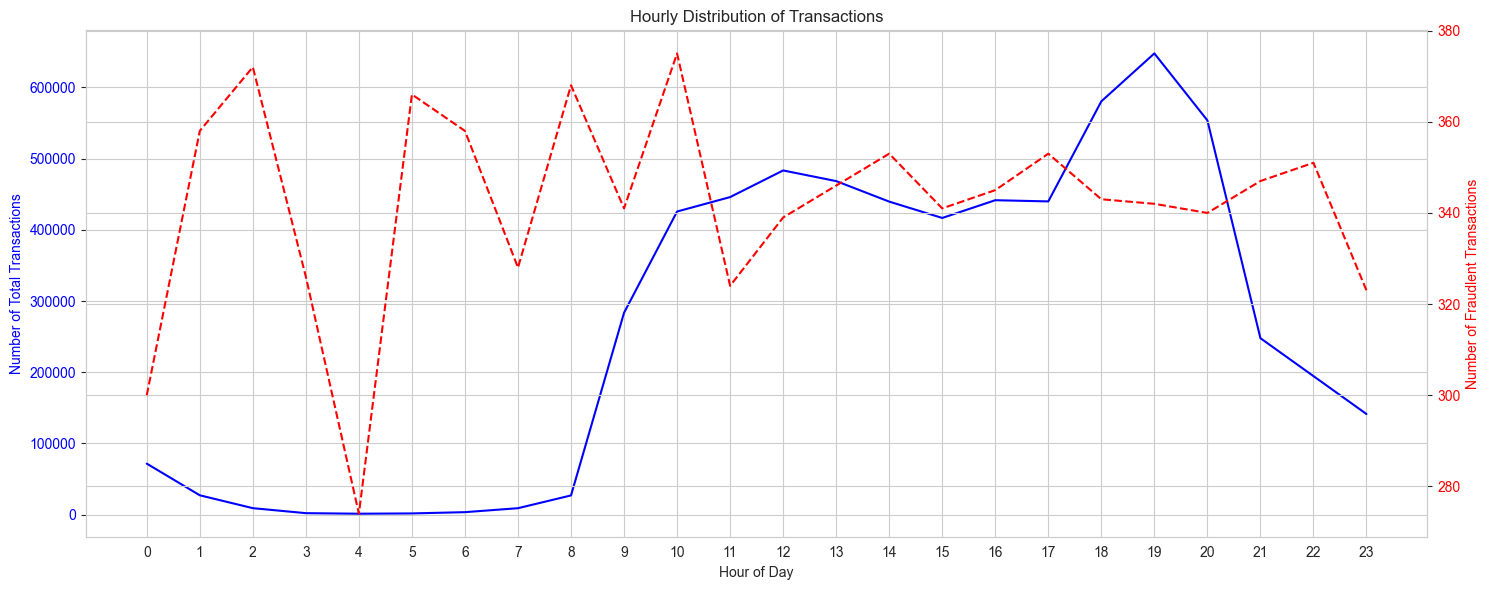

In [51]:
plt.figure(figsize=(15, 6))

ax1 = plt.gca()
ax1.plot(hourly_analysis['hour_of_day'], hourly_analysis['total_transactions'], label='Total Transactions', color='blue')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Total Transactions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(hourly_analysis['hour_of_day'], hourly_analysis['fraudelent_transactions'], label='Fraudlent Transactions', color='red', linestyle='dashed')
ax2.set_ylabel('Number of Fraudlent Transactions', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Hourly Distribution of Transactions')
plt.xticks(range(0, 24))
plt.tight_layout()
save_fig('hourly_distribution_transactions.png')

plt.show()

## Feature Importance

### Statistical Tests

In [52]:
from scipy.stats import ttest_ind, chi2_contingency

np.random.seed(0)
group_X = np.random.normal(50, 10 , 100)
group_Y = np.random.normal(55, 10, 100)

t_stat, p_value = ttest_ind(group_X, group_Y)

p_value

0.00040627960203623554

In [53]:
data_chi2 = {
    'Preference': np.random.choice(['Red', 'Blue', 'Green'], 300, p=[0.5, 0.3, 0.2]),
    'Gender': np.random.choice(['Male', 'Female'], 300, p=[0.6, 0.4]),
}

chi2_df = pd.DataFrame(data_chi2)
contingency_table_chi2 = pd.crosstab(chi2_df['Preference'], chi2_df['Gender'])

chi2_stat, chi2_p_value_sample, dof, expected = chi2_contingency(contingency_table_chi2)

chi2_p_value_sample

0.6970376885104776

In [54]:
from scipy.stats import ttest_ind, chi2_contingency

def ttest(data, feature):
    group1 = data[data['isFraud'] == 0][feature]
    group2 = data[data['isFraud'] == 1][feature]

    t_stat, p = ttest_ind(group1, group2)
    return p

def chi2_test(data, feature):
    contingency_table = pd.crosstab(data[feature], data['isFraud'])

    stat, p, dof, expected = chi2_contingency(contingency_table)
    return p

In [55]:
continuous_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balanceDiffOrig', 'balanceDiffDest', 'log_amount']
categorical_features = ['type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

In [56]:
ttest_results = {feature: ttest(data_encoded, feature) for feature in continuous_features}
chi2_results = {feature: chi2_test(data_encoded, feature) for feature in categorical_features}

In [57]:
ttest_results

{'amount': 0.0,
 'oldbalanceOrg': 1.0542893553023227e-144,
 'newbalanceOrig': 7.168312431103147e-94,
 'oldbalanceDest': 7.463206943535623e-50,
 'newbalanceDest': 0.17689674407002928,
 'balanceDiffOrig': 0.0,
 'balanceDiffDest': 0.0,
 'log_amount': 0.0}

In [58]:
chi2_results

{'type_CASH_OUT': 3.568458816669272e-177,
 'type_DEBIT': 3.512829753658977e-13,
 'type_PAYMENT': 0.0,
 'type_TRANSFER': 0.0}

In [59]:
all_pvalues = {**ttest_results, **chi2_results}

adjusted_pvalues = {}
for key, value in all_pvalues.items():
    epsilon = 1e-300
    if value < epsilon:
        adjusted_pvalues[key] = epsilon
    else:
        adjusted_pvalues[key] = value


negative_log_pvalues = {key: -np.log10(value) for key, value in adjusted_pvalues.items()}

sorted_pvalues = dict(sorted(negative_log_pvalues.items(), key=lambda item: item[1], reverse=True))

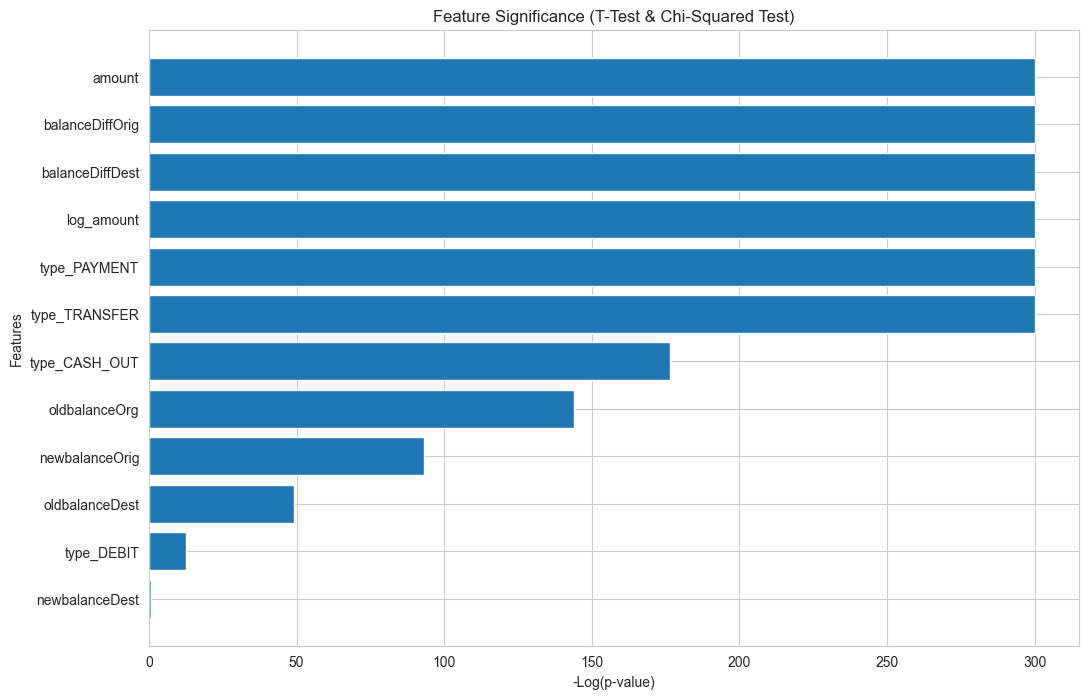

In [60]:
plt.figure(figsize=(12, 8))
plt.barh(list(sorted_pvalues.keys()), list(sorted_pvalues.values()))
plt.xlabel('-Log(p-value)')
plt.ylabel('Features')
plt.title('Feature Significance (T-Test & Chi-Squared Test)')
plt.gca().invert_yaxis()
save_fig('feature_significance_tests.png')

plt.show()

### Permutation Importance

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data_sample = data_encoded.sample(frac=0.1, random_state=42)

X = data_sample.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = data_sample['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

print("Model accuracy on test set:", clf.score(X_test, y_test))

Model accuracy on test set: 0.9997066204244573


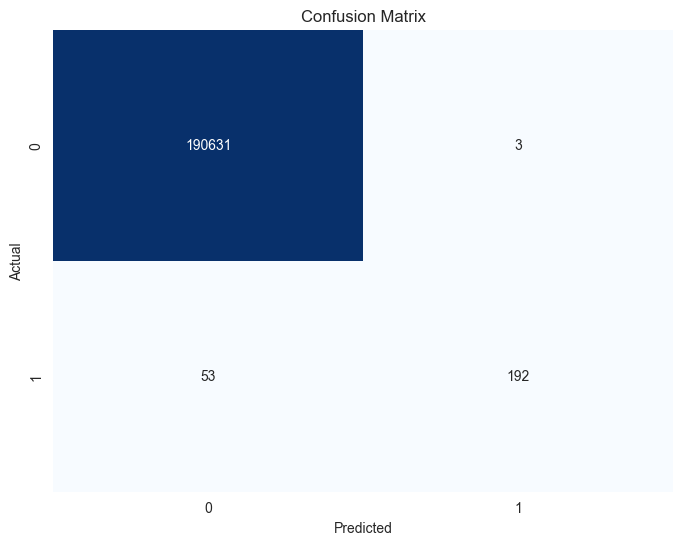

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190634
           1       0.98      0.78      0.87       245

    accuracy                           1.00    190879
   macro avg       0.99      0.89      0.94    190879
weighted avg       1.00      1.00      1.00    190879



In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
save_fig('confusion_matrix.png')

plt.show()

report = classification_report(y_test, y_pred)
print(report)

In [63]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

sorted_idx = perm_importance.importances_mean.argsort()

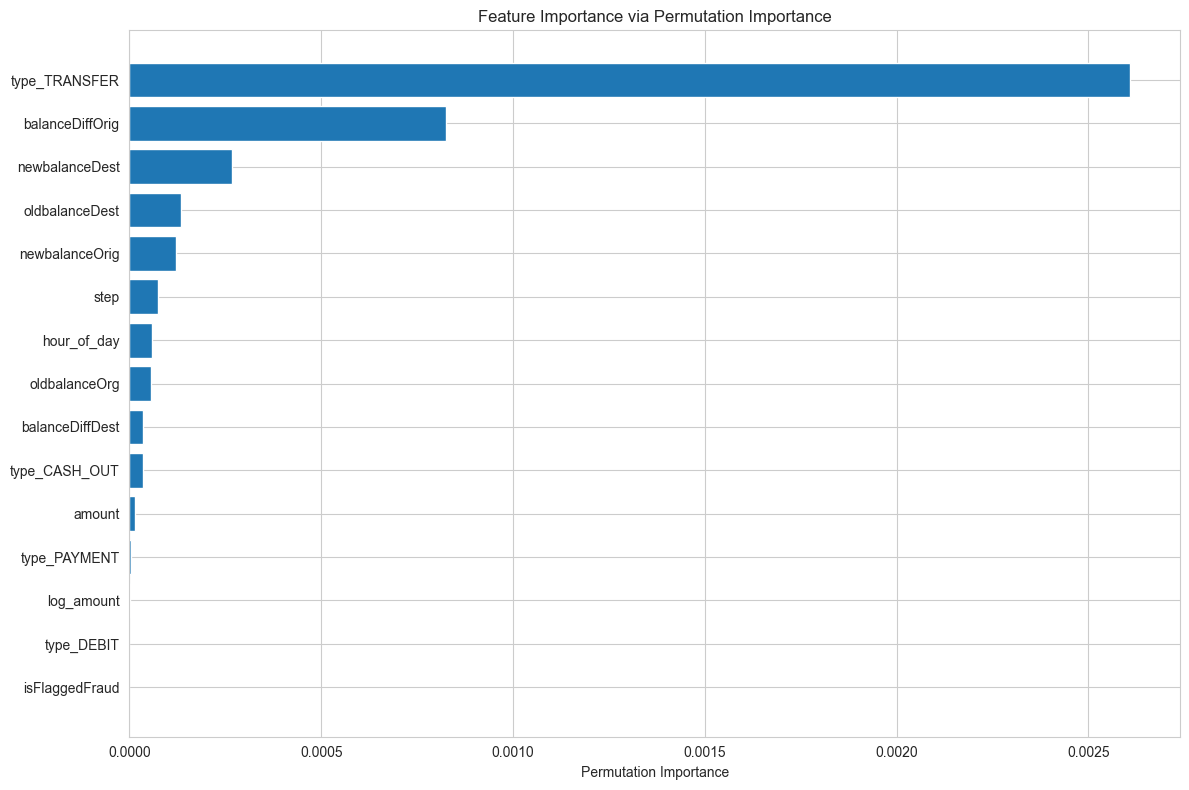

In [64]:
plt.figure(figsize=(12, 8))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation Importance')
plt.tight_layout()
plt.show()

In [65]:
from sklearn.preprocessing import StandardScaler

key_features = ['amount', 'balanceDiffOrig']
plot_data = data_encoded[key_features + ['isFraud']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(plot_data[key_features])
plot_data_scaled = pd.DataFrame(scaled_features, columns=key_features)
plot_data_scaled['isFraud'] = plot_data['isFraud'].values

colors = plot_data_scaled['isFraud'].map({0: 'blue', 1: 'red'})

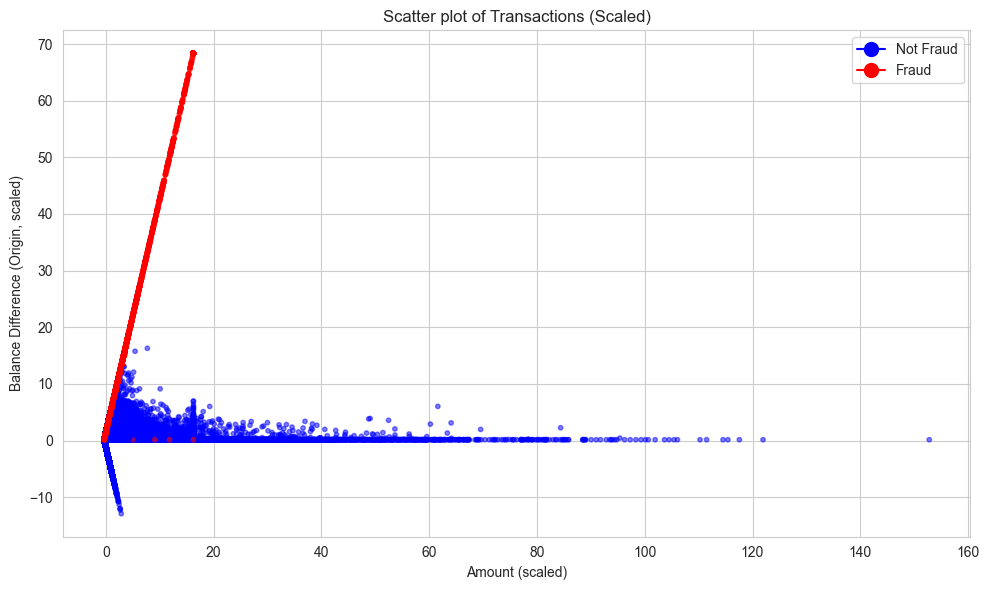

In [66]:
plt.figure(figsize=(10, 6))

plt.scatter(plot_data_scaled['amount'], plot_data_scaled['balanceDiffOrig'], c=colors, alpha=0.5, s=10, label='isFraud')
plt.title('Scatter plot of Transactions (Scaled)')
plt.xlabel('Amount (scaled)')
plt.ylabel('Balance Difference (Origin, scaled)')
plt.legend(handles=[plt.Line2D([0], [0], color='blue', marker='o', markersize=10, label='Not Fraud'),
                    plt.Line2D([0], [0], color='red', marker='o', markersize=10, label='Fraud')],
            loc='upper right')
plt.grid(True)
plt.tight_layout()
save_fig('transactions_scatter_scaled.png')

plt.show()